# Analytics Zoo Recommendation Part 3
> Applying Wide&Deep on MovieLens using Analytics Zoo library

- toc: true
- badges: true
- comments: true
- categories: [movie, BigData, PySpark, AnalyticsZoo, Wide&Deep]
- author: "<a href='https://nbviewer.jupyter.org/github/intel-analytics/analytics-zoo/blob/master/apps/recommendation-wide-n-deep/wide_n_deep.ipynb'>Analytics Zoo</a>"
- image:

## Introduction

Wide and Deep Learning Model, proposed by Google in 2016, is a DNN-Linear mixed model. Wide and deep learning has been used for Google App Store for their app recommendation.

In this tutorial, we use Recommender API of Analytics Zoo to build a wide linear model and a deep neural network, which is called Wide&Deep model, and use optimizer of BigDL to train the neural network. Wide&Deep model combines the strength of memorization and generalization. It's useful for generic large-scale regression and classification problems with sparse input features (e.g., categorical features with a large number of possible feature values).

Python interface:

```python
wide_and_deep = WideAndDeep(class_num, column_info, model_type="wide_n_deep", hidden_layers=(40, 20, 10))
```

- `class_num`: The number of classes. Positive int.
- `column_info`: An instance of ColumnFeatureInfo.
- `model_type`: String. 'wide', 'deep' and 'wide_n_deep' are supported. Default is 'wide_n_deep'.
- `hidden_layers`: Units of hidden layers for the deep model. Tuple of positive int. Default is (40, 20, 10).

## Installation

### Install Java 8

Run the command on the colaboratory file to install jdk 1.8

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Set jdk environment path which enables you to run Pyspark in your Colab environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


### Install Analytics Zoo from pip

You can add the following command on your colab file to install the analytics-zoo via pip easily:

In [ ]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install analytics-zoo

     |████████████████████████████████| 158.9MB 71kB/s 
     |████████████████████████████████| 114.1MB 98kB/s 
     |████████████████████████████████| 215.6MB 66kB/s 
     |████████████████████████████████| 204kB 54.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.3-py2.py3-none-any.whl size=215964968 sha256=1c11d029fe0c7a5df261021ecbcd68c5f0eba457706345103bc5a1969c623224
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark


### Initialize context

Call init_nncontext() that will create a SparkContext with optimized performance configurations.

In [ ]:
from zoo.common.nncontext import*

sc = init_nncontext()

Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar pyspark-shell 


Analytics Zoo provides three Recommenders, including Wide and Deep (WND) model, Neural network-based Collaborative Filtering (NCF) model and Session Recommender model. Easy-to-use Keras-Style defined models which provides compile and fit methods for training. Alternatively, they could be fed into NNFrames or BigDL Optimizer.

WND and NCF recommenders can handle either explict or implicit feedback, given corresponding features.

## Imports

In [ ]:
from zoo.models.recommendation import *
from zoo.models.recommendation.utils import *
from zoo.common.nncontext import init_nncontext

sqlContext = SQLContext(sc)
from pyspark.sql.types import *
from pyspark.sql import Row

import os
import sys
import datetime as dt
import numpy as np
from sklearn import preprocessing

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Download movielens dataset

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-06-27 14:05:35--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.2’

ml-1m.zip.2         100%[===================>]   5.64M  25.4MB/s    in 0.2s    

2021-06-27 14:05:35 (25.4 MB/s) - ‘ml-1m.zip.2’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


## Read the dataset

In [ ]:
def read_data_sets(data_dir):
  rating_files = os.path.join(data_dir,"ratings.dat")
  rating_list = [i.strip().split("::") for i in open(rating_files,"r").readlines()]    
  movielens_data = np.array(rating_list).astype(int)
  return movielens_data 

def get_id_pairs(data_dir):
	movielens_data = read_data_sets(data_dir)
	return movielens_data[:, 0:2]

def get_id_ratings(data_dir):
	movielens_data = read_data_sets(data_dir)
	return movielens_data[:100000, 0:3]

In [ ]:
movielens_data = get_id_ratings("/content/ml-1m")

## Understand the data

In [ ]:
min_user_id = np.min(movielens_data[:,0])
max_user_id = np.max(movielens_data[:,0])
min_movie_id = np.min(movielens_data[:,1])
max_movie_id = np.max(movielens_data[:,1])
rating_labels= np.unique(movielens_data[:,2])

print(movielens_data.shape)
print(min_user_id, max_user_id, min_movie_id, max_movie_id, rating_labels)

(100000, 3)
1 669 1 3952 [1 2 3 4 5]


## Transformation

Transform ratings into dataframe, read user and item data into dataframes. Transform labels to zero-based since the original labels start from 1.

In [ ]:
Rating = Row("userId", "itemId", "label")
User = Row("userId", "gender", "age" ,"occupation")
Item = Row("itemId", "title" ,"genres")

ratings = sc.parallelize(movielens_data)\
    .map(lambda l: (int(l[0]), int(l[1]), int(l[2])-1))\
    .map(lambda r: Rating(*r))
ratingDF = sqlContext.createDataFrame(ratings)

users= sc.textFile("/content/ml-1m/users.dat")\
    .map(lambda l: l.split("::")[0:4])\
    .map(lambda l: (int(l[0]), l[1], int(l[2]), int(l[3])))\
    .map(lambda r: User(*r))
userDF = sqlContext.createDataFrame(users)

items = sc.textFile("/content/ml-1m/movies.dat")\
    .map(lambda l: l.split("::")[0:3])\
    .map(lambda l: (int(l[0]), l[1], l[2].split('|')[0]))\
    .map(lambda r: Item(*r))
itemDF = sqlContext.createDataFrame(items)

Join data together, and transform data. For example, gender is going be used as categorical feature, occupation and gender will be used as crossed features.

In [ ]:
from pyspark.sql.functions import col, udf

gender_udf = udf(lambda gender: categorical_from_vocab_list(gender, ["F", "M"], start=1))
bucket_cross_udf = udf(lambda feature1, feature2: hash_bucket(str(feature1) + "_" + str(feature2), bucket_size=100))
genres_list = ["Crime", "Romance", "Thriller", "Adventure", "Drama", "Children's",
      "War", "Documentary", "Fantasy", "Mystery", "Musical", "Animation", "Film-Noir", "Horror",
      "Western", "Comedy", "Action", "Sci-Fi"]
genres_udf = udf(lambda genres: categorical_from_vocab_list(genres, genres_list, start=1))
     
allDF = ratingDF.join(userDF, ["userId"]).join(itemDF, ["itemId"]) \
        .withColumn("gender", gender_udf(col("gender")).cast("int")) \
        .withColumn("age-gender", bucket_cross_udf(col("age"), col("gender")).cast("int")) \
        .withColumn("genres", genres_udf(col("genres")).cast("int"))
allDF.show(5)

+------+------+-----+------+---+----------+--------------+------+----------+
|itemId|userId|label|gender|age|occupation|         title|genres|age-gender|
+------+------+-----+------+---+----------+--------------+------+----------+
|    26|   229|    3|     2| 18|        10|Othello (1995)|     5|        72|
|    26|   342|    3|     2| 18|        12|Othello (1995)|     5|        72|
|    26|   655|    2|     1| 25|         2|Othello (1995)|     5|         1|
|    26|   524|    2|     2| 18|         0|Othello (1995)|     5|        72|
|    26|    18|    3|     1| 18|         3|Othello (1995)|     5|        77|
+------+------+-----+------+---+----------+--------------+------+----------+
only showing top 5 rows



Speficy data feature information shared by the WideAndDeep model and its feature generation. Here, we use occupation gender for wide base part, age and gender crossed as wide cross part, genres and gender as indicators, userid and itemid for embedding.

In [ ]:
bucket_size = 100
column_info = ColumnFeatureInfo(
            wide_base_cols=["occupation", "gender"],
            wide_base_dims=[21, 3],
            wide_cross_cols=["age-gender"],
            wide_cross_dims=[bucket_size],
            indicator_cols=["genres", "gender"],
            indicator_dims=[19, 3],
            embed_cols=["userId", "itemId"],
            embed_in_dims=[max_user_id, max_movie_id],
            embed_out_dims=[64, 64],
            continuous_cols=["age"])

Transform data to RDD of Sample. We use optimizer of BigDL directly to train the model, it requires data to be provided in format of RDD(Sample). A Sample is a BigDL data structure which can be constructed using 2 numpy arrays, feature and label respectively. The API interface is Sample.from_ndarray(feature, label). Wide&Deep model need two input tensors, one is SparseTensor for the Wide model, another is a DenseTensor for the Deep model.

Randomly split the data into train (80%) and validation (20%)

In [ ]:
rdds = allDF.rdd.map(lambda row: to_user_item_feature(row, column_info))
trainPairFeatureRdds, valPairFeatureRdds = rdds.randomSplit([0.8, 0.2], seed= 1)
valPairFeatureRdds.persist()

train_data= trainPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)
test_data= valPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)

In [ ]:
train_data.count()

80151

In [ ]:
train_data.take(3)

[Sample: features: [JTensor: storage: [1. 1. 1.], shape: [124] ,indices [10 23 96], float, JTensor: storage: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape: [22], float, JTensor: storage: [229.  26.], shape: [2], float, JTensor: storage: [18.], shape: [1], float], labels: [JTensor: storage: [3.], shape: [1], float],
 Sample: features: [JTensor: storage: [1. 1. 1.], shape: [124] ,indices [ 2 22 25], float, JTensor: storage: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape: [22], float, JTensor: storage: [655.  26.], shape: [2], float, JTensor: storage: [25.], shape: [1], float], labels: [JTensor: storage: [2.], shape: [1], float],
 Sample: features: [JTensor: storage: [1. 1. 1.], shape: [124] ,indices [ 0 23 96], float, JTensor: storage: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape: [22], float, JTensor: storage: [524.  26.], shape: [2], float, JTensor: storage: [18.], shape: [1], float], labels: [JTenso

## Build model

In Analytics Zoo, it is simple to build Wide&Deep model by calling WideAndDeep API. You need specify model type, and class number, as well as column information of features according to your data. You can also change other default parameters in the network, like hidden layers. The model could be fed into an Optimizer of BigDL or NNClassifier of analytics-zoo. Please refer to the document for more details. In this example, we demostrate how to use optimizer of BigDL.

In [ ]:
wide_n_deep = WideAndDeep(5, column_info, "wide_n_deep")

creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasSparseDense
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasEmbedding
creating: createZooKerasFlatten
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasEmbedding
creating: createZooKerasFlatten
creating: createZooKerasMerge
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasMerge
creating: createZooKerasActivation
creating: createZooKerasModel
creating: createZooWideAndDeep


### Create optimizer and train the model

In [ ]:
wide_n_deep.compile(optimizer = "adam",
                    loss= "sparse_categorical_crossentropy",
                    metrics=['accuracy'])

creating: createAdam
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createZooKerasSparseCategoricalAccuracy


In [ ]:
tmp_log_dir = create_tmp_path()
wide_n_deep.set_tensorboard(tmp_log_dir, "training_wideanddeep")

Train the network. Wait some time till it finished.. Voila! You've got a trained model



In [ ]:
%%time
# Boot training process
wide_n_deep.fit(train_data,
                batch_size = 20000,
                nb_epoch = 10,
                validation_data = test_data)
print("Optimization Done.")

Optimization Done.
CPU times: user 478 ms, sys: 57.8 ms, total: 535 ms
Wall time: 1min 19s


## Prediction

Zoo models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted label.

In [ ]:
results = wide_n_deep.predict(test_data)
results.take(5)

[array([0.11510788, 0.11794264, 0.20563757, 0.437561  , 0.12375093],
       dtype=float32),
 array([0.02078348, 0.03359406, 0.22935031, 0.20971832, 0.5065538 ],
       dtype=float32),
 array([0.07785287, 0.06622984, 0.32682514, 0.37786472, 0.15122744],
       dtype=float32),
 array([0.08764142, 0.05253283, 0.22836466, 0.34160003, 0.28986108],
       dtype=float32),
 array([0.09743527, 0.07298197, 0.31074455, 0.3314138 , 0.18742438],
       dtype=float32)]

In [ ]:
results_class = wide_n_deep.predict_class(test_data)
results_class.take(5)

[4, 5, 4, 4, 4]

In Analytics Zoo, Recommender has provied 3 unique APIs to predict user-item pairs and make recommendations for users or items given candidates.

### Predict for user item pairs

In [ ]:
userItemPairPrediction = wide_n_deep.predict_user_item_pair(valPairFeatureRdds)
for result in userItemPairPrediction.take(5): print(result)

UserItemPrediction [user_id: 342, item_id: 26, prediction: 4, probability: 0.4375610053539276]
UserItemPrediction [user_id: 602, item_id: 29, prediction: 5, probability: 0.5065538287162781]
UserItemPrediction [user_id: 5, item_id: 29, prediction: 4, probability: 0.3778647184371948]
UserItemPrediction [user_id: 623, item_id: 29, prediction: 4, probability: 0.3416000306606293]
UserItemPrediction [user_id: 563, item_id: 29, prediction: 4, probability: 0.33141380548477173]


### Recommend 3 items for each user given candidates in the feature RDDs

In [ ]:
userRecs = wide_n_deep.recommend_for_user(valPairFeatureRdds, 3)
for result in userRecs.take(5): print(result)

UserItemPrediction [user_id: 600, item_id: 2987, prediction: 4, probability: 0.48497775197029114]
UserItemPrediction [user_id: 600, item_id: 2701, prediction: 4, probability: 0.47248759865760803]
UserItemPrediction [user_id: 600, item_id: 104, prediction: 4, probability: 0.4457840323448181]
UserItemPrediction [user_id: 200, item_id: 2555, prediction: 5, probability: 0.2934740483760834]
UserItemPrediction [user_id: 200, item_id: 2041, prediction: 3, probability: 0.3036503791809082]


### Recommend 3 users for each item given candidates in the feature RDDs

In [ ]:
itemRecs = wide_n_deep.recommend_for_item(valPairFeatureRdds, 3)
for result in itemRecs.take(5): print(result)

UserItemPrediction [user_id: 412, item_id: 1200, prediction: 5, probability: 0.4764344394207001]
UserItemPrediction [user_id: 661, item_id: 1200, prediction: 5, probability: 0.47617384791374207]
UserItemPrediction [user_id: 161, item_id: 1200, prediction: 5, probability: 0.47474074363708496]
UserItemPrediction [user_id: 10, item_id: 2000, prediction: 5, probability: 0.3568936884403229]
UserItemPrediction [user_id: 101, item_id: 2000, prediction: 5, probability: 0.3536785840988159]


## Evaluation

Plot the train and validation loss curves

Text(0.5, 1.0, 'loss')

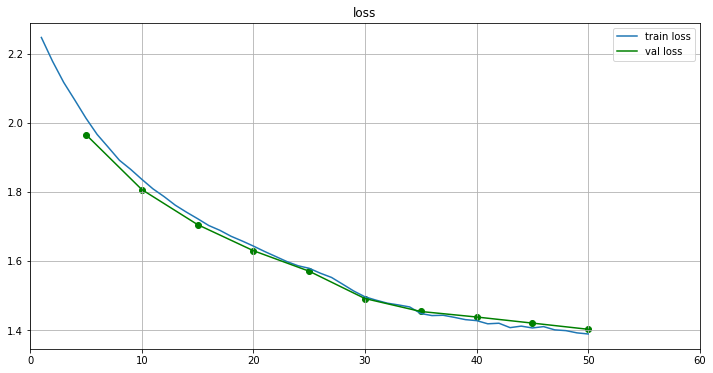

In [ ]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
train_loss = np.array(wide_n_deep.get_train_summary("Loss"))
val_loss = np.array(wide_n_deep.get_validation_summary("Loss"))
#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.figure(figsize = (12,6))
plt.plot(train_loss[:,0],train_loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='val loss',color='green')
plt.scatter(val_loss[:,0],val_loss[:,1],color='green')
plt.legend();
plt.xlim(0,train_loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

Plot accuracy

(0.0, 60.0)

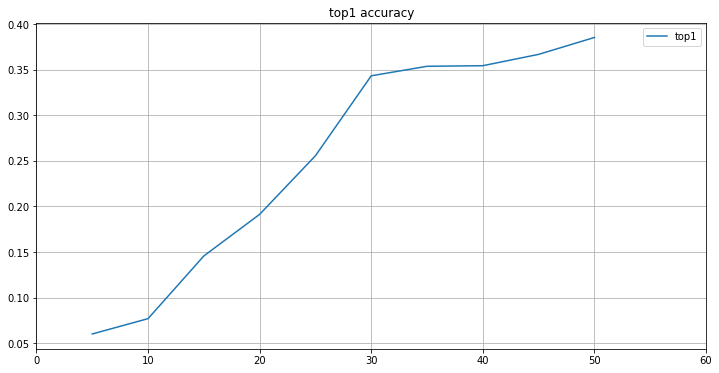

In [ ]:
plt.figure(figsize = (12,6))
top1 = np.array(wide_n_deep.get_validation_summary("Top1Accuracy"))
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.title("top1 accuracy")
plt.grid(True)
plt.legend();
plt.xlim(0,train_loss.shape[0]+10)

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir $tmp_log_dir/training_wideanddeep/

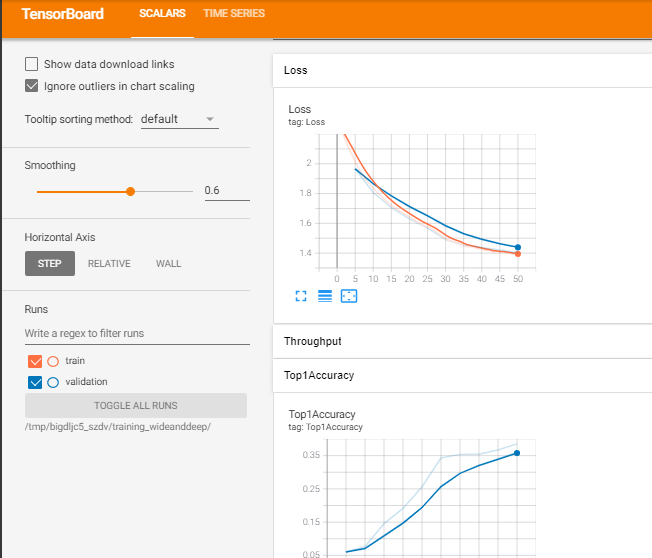